# Mask R-CNN Demo

A quick intro to using the pre-trained model to detect and segment objects.

In [2]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn1 import utils
import mrcnn1.model as modellib
import cv2
from mrcnn1 import visualize

# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))  # To find local version
import coco

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "images")

## Configurations

We'll be using a model trained on the MS-COCO dataset. The configurations of this model are in the ```CocoConfig``` class in ```coco.py```.

For inferencing, modify the configurations a bit to fit the task. To do so, sub-class the ```CocoConfig``` class and override the attributes you need to change.

In [175]:
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

## Create Model and Load Trained Weights

In [176]:
# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Load weights trained on MS-COCO
model.load_weights("/home/dhruvi/Mask_RCNN/mask_rcnn_coco.h5", by_name=True)

## Class Names

The model classifies objects and returns class IDs, which are integer value that identify each class. Some datasets assign integer values to their classes and some don't. For example, in the MS-COCO dataset, the 'person' class is 1 and 'teddy bear' is 88. The IDs are often sequential, but not always. The COCO dataset, for example, has classes associated with class IDs 70 and 72, but not 71.

To improve consistency, and to support training on data from multiple sources at the same time, our ```Dataset``` class assigns it's own sequential integer IDs to each class. For example, if you load the COCO dataset using our ```Dataset``` class, the 'person' class would get class ID = 1 (just like COCO) and the 'teddy bear' class is 78 (different from COCO). Keep that in mind when mapping class IDs to class names.

To get the list of class names, you'd load the dataset and then use the ```class_names``` property like this.
```
# Load COCO dataset
dataset = coco.CocoDataset()
dataset.load_coco(COCO_DIR, "train")
dataset.prepare()

# Print class names
print(dataset.class_names)
```

We don't want to require you to download the COCO dataset just to run this demo, so we're including the list of class names below. The index of the class name in the list represent its ID (first class is 0, second is 1, third is 2, ...etc.)

In [177]:
# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']


## Run Object Detection

In [417]:
# Load a random image from the images folder
import os 
import random 
import skimage

from mrcnn1 import visualize
# from mrcnn import model
IMAGE_DIR = '/home/dhruvi/work/ai_photo_editing/image_dataset/all_unedited_images/final_edited'
file_names = next(os.walk(IMAGE_DIR))[2]
image = skimage.io.imread(os.path.join(IMAGE_DIR, random.choice(file_names)))

# Run detection
results = model.detect([image], verbose=1)

# print(results[0]['masks'].shape)
# Visualize results
# print(results)


IN DETECT
Processing 1 images
image                    shape: (4024, 6024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 6024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
********************
++++++++++++++++++++++++++++++++++ [ 1  1  1  1  1  1 28  1]
******************** [ 1  1  1  1  1  1 28  1]
<class 'numpy.ndarray'>
final_scores:  [0.9987098  0.9967604  0.9918202  0.96885216 0.96580696 0.95225495
 0.9229141  0.8145844 ]
filtered_scores:  [0.9987098  0.9967604  0.9918202  0.96885216 0.96580696 0.95225495
 0.9229141 ]


In [418]:
# cv2.imwrite("/home/dhruvi/Mask_RCNN/temp.jpg", mask)

N is:       8
boxes.shape[0]:        8
masks.shape[-1]:      8
class_ids.shape[0]:         8


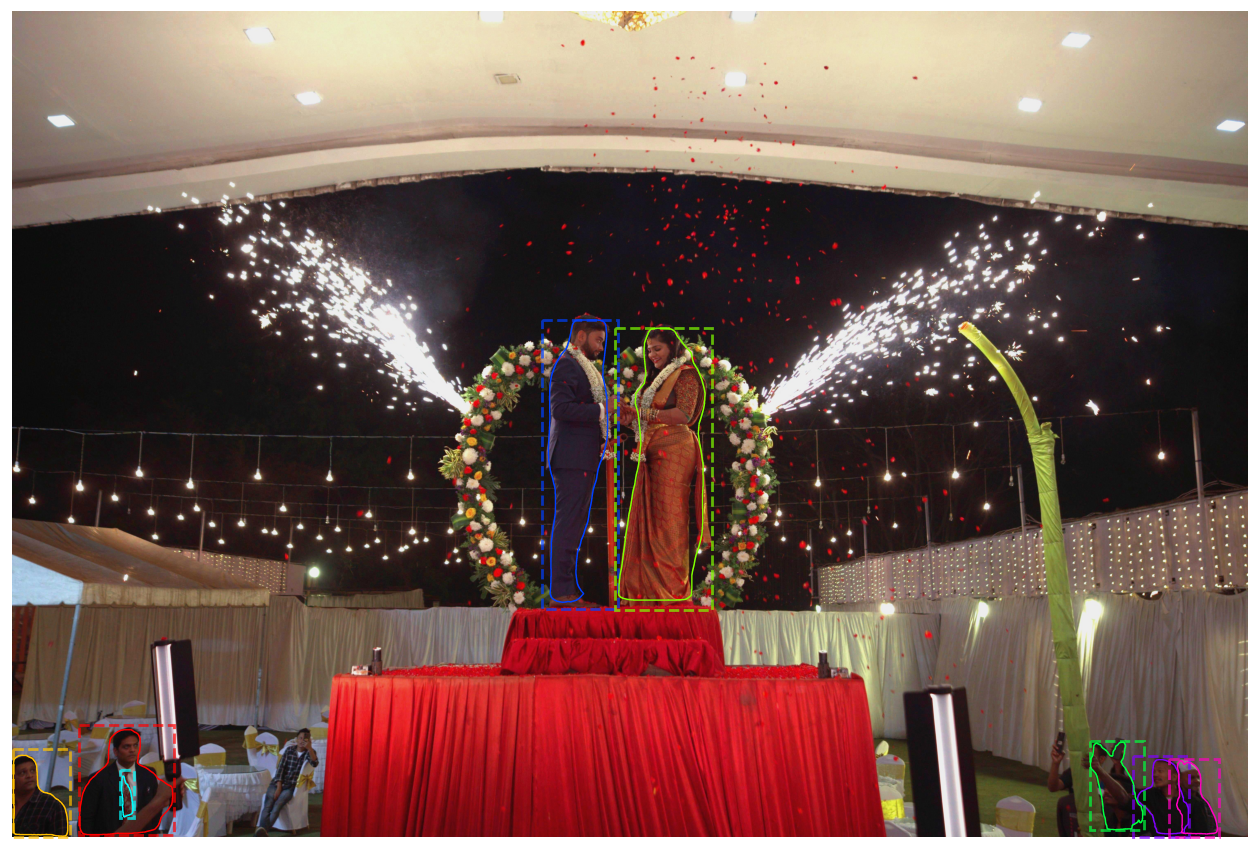

In [419]:
r = results[0]
# print(r['masks'])
# #visualizing data
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], class_names, r['scores'])

N is:       8
boxes.shape[0]:        8
masks.shape[-1]:      8
class_ids.shape[0]:         8


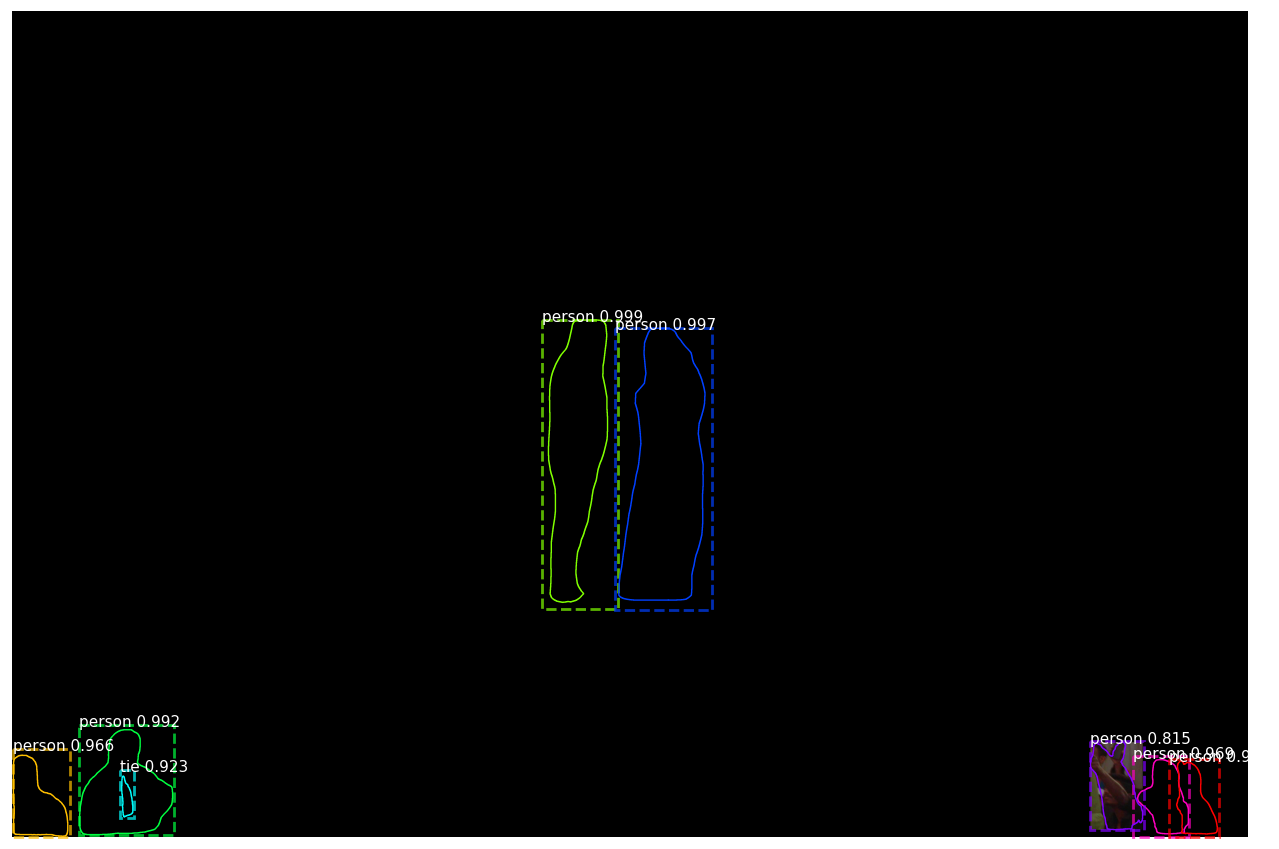

In [420]:
visualize.display_instances_masked_only(image, r['rois'], r['masks'], r['class_ids'], class_names, r['scores'])

In [421]:
r["masks"].shape
r = results[0]
converted_mask = r["masks"]
mask = converted_mask.astype(np.uint8)

In [422]:
image

array([[[144, 127, 109],
        [144, 127, 109],
        [144, 127, 109],
        ...,
        [146, 138, 115],
        [144, 136, 113],
        [143, 135, 112]],

       [[144, 127, 109],
        [144, 127, 109],
        [144, 127, 109],
        ...,
        [146, 138, 115],
        [144, 136, 113],
        [144, 136, 113]],

       [[144, 127, 109],
        [144, 127, 109],
        [144, 127, 109],
        ...,
        [145, 137, 114],
        [145, 137, 114],
        [144, 136, 113]],

       ...,

       [[ 17,  23,  21],
        [ 16,  22,  20],
        [ 15,  21,  19],
        ...,
        [ 84,  36,  36],
        [ 86,  36,  37],
        [ 87,  37,  38]],

       [[ 18,  24,  22],
        [ 17,  23,  21],
        [ 15,  21,  19],
        ...,
        [ 81,  33,  33],
        [ 84,  34,  35],
        [ 85,  33,  35]],

       [[ 19,  25,  23],
        [ 18,  24,  22],
        [ 16,  22,  20],
        ...,
        [ 79,  31,  31],
        [ 83,  31,  33],
        [ 84,  32,  34]]

In [423]:
mask

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

In [424]:
# Convert the mask to a binary mask (0 or 1)
binary_mask = np.any(mask, axis=-1).astype(np.uint8)

# Invert the binary mask (to get the foreground instead of the masked part)
inverted_mask = 1 - binary_mask

# Apply the inverted mask to the original image
background_image = image * inverted_mask[..., np.newaxis]

In [425]:
image_rgb = cv2.cvtColor(background_image, cv2.COLOR_BGR2RGB)

In [426]:
cv2.imwrite("/home/dhruvi/Mask_RCNN/temp.jpg", image_rgb)

True

In [427]:
# # image = Image.open('/home/dhruvi/Mask_RCNN/temp1.jpg').convert('RGBA')

# # # Create a new transparent mask image of the same size
# # mask = Image.new('RGBA', image.size, (0, 0, 0, 0))

# # result = Image.alpha_composite(image, mask)

# # # Save the result with transparency as a PNG image
# # result.save('masked_image121.png')
# image = Image.open('/home/dhruvi/Mask_RCNN/temp.jpg')

# # Convert the image to RGBA mode
# image = image.convert('RGBA')

# # Get the pixel data
# pixels = list(image.getdata())

# # Replace black pixels with transparent pixels
# new_pixels = [(r, g, b, 0) if (r, g, b) == (0, 0, 0) else (r, g, b, a) for r, g, b, a in pixels]

# # Update the image with the modified pixel data
# image.putdata(new_pixels)

# # Save the result with transparency as PNG
# image.save('transparent_image.png')

In [428]:
# Resize the mask to match the original image dimensions (if needed)
resized_mask = cv2.resize(mask, (image.shape[1], image.shape[0]))

# Convert the resized mask to a binary mask (0 or 1)
binary_mask = np.any(resized_mask, axis=-1).astype(np.uint8)

# Merge the mask into the original image using bitwise AND
foreground_image = cv2.bitwise_and(image, image, mask=binary_mask)


In [429]:
image_rgb = cv2.cvtColor(foreground_image, cv2.COLOR_BGR2RGB)

In [430]:
cv2.imwrite("/home/dhruvi/Mask_RCNN/temp1.jpg", image_rgb)

True

In [431]:
# # image = Image.open('/home/dhruvi/Mask_RCNN/temp1.jpg').convert('RGBA')

# # # Create a new transparent mask image of the same size
# # mask = Image.new('RGBA', image.size, (0, 0, 0, 0))

# # result = Image.alpha_composite(image, mask)

# # # Save the result with transparency as a PNG image
# # result.save('masked_image121.png')
# image = Image.open('/home/dhruvi/Mask_RCNN/temp1.jpg')

# # Convert the image to RGBA mode
# image = image.convert('RGBA')

# # Get the pixel data
# pixels = list(image.getdata())

# # Replace black pixels with transparent pixels
# new_pixels = [(r, g, b, 0) if (r, g, b) == (0, 0, 0) else (r, g, b, a) for r, g, b, a in pixels]

# # Update the image with the modified pixel data
# image.putdata(new_pixels)

# # Save the result with transparency as PNG
# image.save('transparent_image1.png')

In [432]:
import cv2
from PIL import Image, ImageEnhance

In [433]:
def div_light_percentage(filepath):

    # Load image as greyscale
    
    im = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    
    if im is None:
        print(f'ERROR: Unable to load {filepath}')

    # Calculate mean brightness as percentage
    meanpercent = np.mean(im) * 100 / 255

    return meanpercent

In [434]:
def find_div_light(topleft_filepath):
# taking light percentage
    top_left_light_percentage = div_light_percentage(topleft_filepath)

    return (top_left_light_percentage)

In [435]:
def brightness_parameter(percentage):

    # define the range
    min_value = 1.3
    max_value = 1.7

    # calculate the actual value based on percentage
    actual_value = min_value + percentage/100 * (max_value - min_value)

    # check if actual value is within range
    if actual_value < min_value:
        actual_value = min_value
    elif actual_value > max_value:
        actual_value = max_value

    # check if percentage is below 30% and adjust the actual value accordingly
    if percentage < 30:
        actual_value += 0.1
        if actual_value > max_value:
            actual_value = max_value

    return actual_value

In [436]:
# image = Image.open('path/to/your/image.jpg')

# # Adjust the brightness
# enhancer = ImageEnhance.Brightness(image)
# bright_image = enhancer.enhance(0.5) 



# Load the image
image_path = os.path.join('/home/dhruvi/Mask_RCNN','temp.jpg')
image = Image.open(image_path)
# image = cv2.imread(file_path)
# brightness_file_path = os.path.join('/home/dhruvi/Mask_RCNN', 'brightness.jpg')

# -------------------brightness enhancer (enhancer-01)---------------------------
enhancer = ImageEnhance.Brightness(image)

# # dividing image
# Enhancer.image_div(
#     file_path, (topleft_filepath)
# )

# getting maximum light part
max_light_param_value = find_div_light(image_path)

# # selecting brightness parameter
brightness = brightness_parameter(max_light_param_value)
print(brightness)
filtered_image1 = enhancer.enhance(brightness)
brightness = brightness-0.6
print(brightness)
# applying brightness
filtered_image = enhancer.enhance(brightness)
print(filtered_image)

# cv2.imwrite('/home/dhruvi/Mask_RCNN/brightness123.jpg', filtered_image)
filtered_image.save('/home/dhruvi/Mask_RCNN/brightness3.jpg')
filtered_image1.save('/home/dhruvi/Mask_RCNN/brightness4.jpg')

1.4373689446142197
0.8373689446142197
<PIL.Image.Image image mode=RGB size=6024x4024 at 0x7F25869BCB10>


In [437]:
# masked_pixels = image[mask == 1]
# masked_image = np.zeros_like(image)
# masked_image[mask == 1] = masked_pixels

In [438]:
# cv2.imwrite("/home/dhruvi/Mask_RCNN/temp.jpg", image_rgb)

In [439]:
# # image = Image.open('/home/dhruvi/Mask_RCNN/temp1.jpg').convert('RGBA')

# # # Create a new transparent mask image of the same size
# # mask = Image.new('RGBA', image.size, (0, 0, 0, 0))

# # result = Image.alpha_composite(image, mask)

# # # Save the result with transparency as a PNG image
# # result.save('masked_image121.png')
# image = Image.open('/home/dhruvi/Mask_RCNN/temp.jpg')

# # Convert the image to RGBA mode
# image = image.convert('RGBA')

# # Get the pixel data
# pixels = list(image.getdata())

# # Replace black pixels with transparent pixels
# new_pixels = [(r, g, b, 0) if (r, g, b) == (0, 0, 0) else (r, g, b, a) for r, g, b, a in pixels]

# # Update the image with the modified pixel data
# image.putdata(new_pixels)

# # Save the result with transparency as PNG
# image.save('transparent_image.png')

In [440]:
# # Resize the mask to match the original image dimensions (if needed)
# resized_mask = cv2.resize(mask, (image.shape[1], image.shape[0]))

# # Convert the resized mask to a binary mask (0 or 1)
# binary_mask = np.any(resized_mask, axis=-1).astype(np.uint8)

# # Merge the mask into the original image using bitwise AND
# foreground_image = cv2.bitwise_and(image, image, mask=binary_mask)


In [441]:
# cv2.imwrite("/home/dhruvi/Mask_RCNN/temp1.jpg", foreground_image)

In [442]:
# image_rgb = cv2.cvtColor(foreground_image, cv2.COLOR_BGR2RGB)

In [443]:
# cv2.imwrite("/home/dhruvi/Mask_RCNN/temp1.jpg", image_rgb)

In [444]:
original_image = cv2.imread("/home/dhruvi/Mask_RCNN/temp1.jpg")  # Replace "original_image.jpg" with the path to your original image
mask_image = cv2.imread("/home/dhruvi/Mask_RCNN/brightness3.jpg")

In [445]:
# mask_image_resized = cv2.resize(mask_image, (original_image.shape[1], original_image.shape[0]))

# # Define the weight for blending the images
# alpha = 0.5  # Adjust this value to control the blending effect

# # Merge the images using addWeighted()
# merged_image = cv2.addWeighted(original_image, 1 - alpha, mask_image_resized, alpha, 0)
mask_image_resized = cv2.resize(mask_image, (original_image.shape[1], original_image.shape[0]))

# Convert the mask image to grayscale
mask_gray = cv2.cvtColor(mask_image_resized, cv2.COLOR_BGR2GRAY)

# Create an alpha channel from the grayscale mask
_, alpha = cv2.threshold(mask_gray, 0, 255, cv2.THRESH_BINARY)

# Convert alpha to 3-channel format to match original image
alpha = cv2.cvtColor(alpha, cv2.COLOR_GRAY2BGR)

# Normalize the alpha channel to be between 0 and 1
alpha = alpha.astype(float) / 255

# Blend the images using alpha channel
merged_image = (original_image * (1 - alpha) + mask_image_resized * alpha).astype(np.uint8)



In [446]:
cv2.imwrite("/home/dhruvi/Mask_RCNN/temp17.jpg", merged_image)

True

In [253]:
# mask_image_resized = cv2.resize(mask_image, (original_image.shape[1], original_image.shape[0]))

# # Convert the mask image to a binary mask (0 or 255)
# mask = cv2.cvtColor(mask_image_resized, cv2.COLOR_BGR2GRAY)
# ret, binary_mask = cv2.threshold(mask, 1, 255, cv2.THRESH_BINARY)

# # Invert the binary mask (to get the foreground instead of the background)
# inverted_mask = cv2.bitwise_not(binary_mask)

# # Apply the inverted mask to the original image
# foreground = cv2.bitwise_and(original_image, original_image, mask=inverted_mask)

# # Merge the foreground with a white background
# background = np.ones_like(original_image, dtype=np.uint8) * 0
# merged_image = cv2.bitwise_or(foreground, background)

In [ ]:
# # Resize the mask image to match the dimensions of the original image (if needed)
# mask_image_resized = cv2.resize(mask_image, (original_image.shape[1], original_image.shape[0]))

# # Convert the mask image to a binary mask (0 or 255)
# mask = cv2.cvtColor(mask_image_resized, cv2.COLOR_BGR2GRAY)
# ret, binary_mask = cv2.threshold(mask, 1, 255, cv2.THRESH_BINARY)

# # Invert the binary mask (to get the foreground instead of the background)
# inverted_mask = cv2.bitwise_not(binary_mask)

# # Convert the inverted mask to float (0.0 or 1.0) to use it as a blending weight
# inverted_mask_float = inverted_mask.astype(float) / 255

# # Apply the inverted mask as a blending weight
# merged_image = original_image * inverted_mask_float[..., np.newaxis]

In [447]:
!pip freeze

absl-py==1.4.0
alabaster==0.7.13
anyio==3.7.0
argon2-cffi==21.3.0
argon2-cffi-bindings==21.2.0
astor==0.8.1
attrs==23.1.0
Babel==2.12.1
backcall==0.2.0
beautifulsoup4==4.12.2
bleach==6.0.0
certifi==2023.5.7
cffi==1.15.1
charset-normalizer==3.1.0
cycler==0.11.0
Cython==0.29.35
debugpy==1.6.7
decorator==5.1.1
defusedxml==0.7.1
docutils==0.19
entrypoints==0.4
exceptiongroup==1.1.1
fastjsonschema==2.17.1
fonttools==4.38.0
gast==0.2.2
google-pasta==0.2.0
grpcio==1.54.2
h5py==2.10.0
idna==3.4
imageio==2.30.0
imagesize==1.4.1
imgaug==0.4.0
importlib-metadata==6.6.0
importlib-resources==5.12.0
ipykernel==6.16.2
ipyparallel==8.6.1
ipython==7.34.0
ipython-genutils==0.2.0
ipywidgets==8.0.6
jedi==0.18.2
Jinja2==3.1.2
jsonschema==4.17.3
jupyter-server==1.24.0
jupyter_client==7.4.9
jupyter_core==4.12.0
jupyterlab-pygments==0.2.2
jupyterlab-widgets==3.0.7
Keras==2.0.8
Keras-Applications==1.0.8
Keras-Preprocessing==1.1.2
kiwisolver==1.4.4
Markdown==3.4.3
MarkupSafe==2.1.2
matplotlib==3.5.3
matplotlib-